# Code Generator

The requirement: use an Open Source model to generate high performance C++ code from Python code

To replicate this, you'll need to set up a HuggingFace endpoint as I do in the video. It's simple to do, and it's quite satisfying to see the results!

It's also an important part of your learning; this is the first example of deploying an open source model to be behind an API. We'll return to this in Week 8, but this should plant a seed in your mind for what's involved in moving open source models into production.

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../important.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h1 style="color:#900;">Important - Pause Endpoints when not in use</h1>
            <span style="color:#900;">
            If you do decide to use HuggingFace endpoints for this project, you should stop or pause the endpoints when you are done to avoid accruing unnecessary running cost. The costs are very low as long as you only run the endpoint when you're using it. Navigate to the HuggingFace endpoint UI <a href="https://ui.endpoints.huggingface.co/">here,</a> open your endpoint, and click Pause to put it on pause so you no longer pay for it.  
Many thanks to student John L. for raising this.
<br/><br/>
In week 8 we will use Modal instead of HuggingFace endpoints; with Modal you only pay for the time that you use it and you should get free credits.
            </span>
        </td>
    </tr>
</table>

In [ ]:
# imports

import os
import io
import sys
import json
import requests
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import subprocess

In [ ]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

if os.environ['HF_TOKEN'] == 'your-key-if-not-using-env':
    print("Failed to load token, is it inside your .env file?")
else:
    print(f"Successfully loaded token beginning {os.environ['HF_TOKEN'][:5]}")

In [ ]:
# initialize

openai = OpenAI()
claude = anthropic.Anthropic()
hf_inference_provider = OpenAI(base_url="https://api-inference.huggingface.co/v1/", api_key=os.environ['HF_TOKEN'])
OPENAI_MODEL = "gpt-4o"
CLAUDE_MODEL = "claude-3-5-sonnet-20240620"

# New - use Huggingface Provided Inference Endpoint for free - use DEEPSEEK!
* if available, Huggingface is providing their own inference endpoints to some of their models.
* this may change over time, but currently, the below deepseek model is one such model.
* usage is included in the free account limits, so there is no cost unlike the HF Inference Endpoints discussed in day 4.

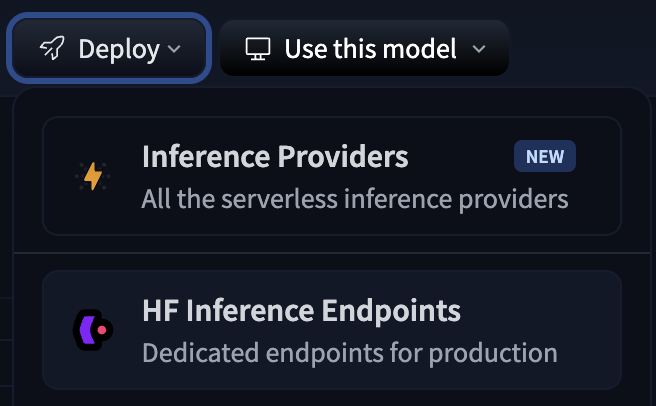

In [ ]:
# endpoint for which this is available from the huggingface site and deploy dropdown
DEEPSEEK_MODEL = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B" 

In [ ]:
system_message = "You are an assistant that reimplements Python code in high performance C++ for an M1 Mac. "
system_message += "Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. "
system_message += "The C++ response needs to produce an identical output in the fastest possible time. Keep implementations of random number generators identical so that results match exactly."

In [ ]:
def user_prompt_for(python):
    user_prompt = "Rewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. "
    user_prompt += "Respond only with C++ code; do not explain your work other than a few comments. "
    user_prompt += "Pay attention to number types to ensure no int overflows. Remember to #include all necessary C++ packages such as iomanip.\n\n"
    user_prompt += python
    return user_prompt

In [ ]:
def messages_for(python):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt_for(python)}
    ]

In [ ]:
# write to a file called optimized.cpp

def write_output(cpp):
    code = cpp.replace("```cpp","").replace("```","")
    with open("optimized.cpp", "w") as f:
        f.write(code)

In [ ]:
def optimize_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        print(fragment, end='', flush=True)
    write_output(reply)

In [ ]:
def optimize_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            print(text, end="", flush=True)
    write_output(reply)

# New function to serve HF Inference Provider model

In [ ]:
def optimize_hf_inference_provider(python):    
    stream = hf_inference_provider.chat.completions.create(model=DEEPSEEK_MODEL, messages=messages_for(python), max_tokens=500, stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        print(fragment, end='', flush=True)
    write_output(reply)

In [ ]:
pi = """
import time

def calculate(iterations, param1, param2):
    result = 1.0
    for i in range(1, iterations+1):
        j = i * param1 - param2
        result -= (1/j)
        j = i * param1 + param2
        result += (1/j)
    return result

start_time = time.time()
result = calculate(100_000_000, 4, 1) * 4
end_time = time.time()

print(f"Result: {result:.12f}")
print(f"Execution Time: {(end_time - start_time):.6f} seconds")
"""

In [ ]:
exec(pi)

In [ ]:
optimize_gpt(pi)

In [ ]:
exec(pi)

In [ ]:
!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

In [ ]:
optimize_claude(pi)

In [ ]:
!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

In [ ]:
python_hard = """# Be careful to support large number sizes

def lcg(seed, a=1664525, c=1013904223, m=2**32):
    value = seed
    while True:
        value = (a * value + c) % m
        yield value
        
def max_subarray_sum(n, seed, min_val, max_val):
    lcg_gen = lcg(seed)
    random_numbers = [next(lcg_gen) % (max_val - min_val + 1) + min_val for _ in range(n)]
    max_sum = float('-inf')
    for i in range(n):
        current_sum = 0
        for j in range(i, n):
            current_sum += random_numbers[j]
            if current_sum > max_sum:
                max_sum = current_sum
    return max_sum

def total_max_subarray_sum(n, initial_seed, min_val, max_val):
    total_sum = 0
    lcg_gen = lcg(initial_seed)
    for _ in range(20):
        seed = next(lcg_gen)
        total_sum += max_subarray_sum(n, seed, min_val, max_val)
    return total_sum

# Parameters
n = 10000         # Number of random numbers
initial_seed = 42 # Initial seed for the LCG
min_val = -10     # Minimum value of random numbers
max_val = 10      # Maximum value of random numbers

# Timing the function
import time
start_time = time.time()
result = total_max_subarray_sum(n, initial_seed, min_val, max_val)
end_time = time.time()

print("Total Maximum Subarray Sum (20 runs):", result)
print("Execution Time: {:.6f} seconds".format(end_time - start_time))
"""

In [ ]:
exec(python_hard)

In [ ]:
optimize_gpt(python_hard)

In [ ]:
!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

In [ ]:
optimize_claude(python_hard)

In [ ]:
!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

In [ ]:
def stream_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

def stream_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            yield reply.replace('```cpp\n','').replace('```','')

# New function to serve HF Inference Provider model

In [ ]:
def stream_hf_inference_provider(python):    
    stream = hf_inference_provider.chat.completions.create(model=DEEPSEEK_MODEL, messages=messages_for(python), max_tokens=500, stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [ ]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    elif model=="HF Inference Model":
        result = stream_hf_inference_provider(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far        

# Updated so you can now run DEEPSEEK!

In [ ]:
with gr.Blocks() as ui:
    with gr.Row():
        python = gr.Textbox(label="Python code:", lines=10, value=python_hard)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude", "HF Inference Model"], label="Select model", value="GPT")
        convert = gr.Button("Convert code")

    convert.click(optimize, inputs=[python, model], outputs=[cpp])

ui.launch(inbrowser=True)

In [ ]:
def execute_python(code):
    try:
        output = io.StringIO()
        sys.stdout = output
        exec(code)
    finally:
        sys.stdout = sys.__stdout__
    return output.getvalue()

In [ ]:
def execute_cpp(code):
    write_output(code)
    try:
        compile_result = subprocess.run(compiler_cmd[2], check=True, text=True, capture_output=True)
        run_cmd = ["./optimized"]
        run_result = subprocess.run(run_cmd, check=True, text=True, capture_output=True)
        return run_result.stdout
    except subprocess.CalledProcessError as e:
        return f"An error occurred:\n{e.stderr}"

In [ ]:
css = """
.python {background-color: #306998;}
.cpp {background-color: #050;}
"""

# Updated so you can now run DEEPSEEK!

In [ ]:
with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude", "HF Inference Model"], label="Select model", value="GPT")
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        cpp_run = gr.Button("Run C++")
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)

In [ ]:
from huggingface_hub import login, InferenceClient
from transformers import AutoTokenizer

In [ ]:
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

In [ ]:
code_qwen = "Qwen/CodeQwen1.5-7B-Chat"
code_gemma = "google/codegemma-7b-it"
CODE_QWEN_URL = "https://h1vdol7jxhje3mpn.us-east-1.aws.endpoints.huggingface.cloud"
CODE_GEMMA_URL = "https://c5hggiyqachmgnqg.us-east-1.aws.endpoints.huggingface.cloud"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(code_qwen)
messages = messages_for(pi)
text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

In [ ]:
print(text)

In [ ]:
client = InferenceClient(CODE_QWEN_URL, token=hf_token)
stream = client.text_generation(text, stream=True, details=True, max_new_tokens=3000)
for r in stream:
    print(r.token.text, end = "")

In [ ]:
def stream_hf_inference_provider(python):
    tokenizer = AutoTokenizer.from_pretrained(code_qwen)
    messages = messages_for(python)
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    client = InferenceClient(CODE_QWEN_URL, token=hf_token)
    stream = client.text_generation(text, stream=True, details=True, max_new_tokens=3000)
    result = ""
    for r in stream:
        result += r.token.text
        yield result    
        

In [ ]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    elif model=="HF Inference Model":
        result = stream_hf_inference_provider(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far    

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../thankyou.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#090;">Thank you to @CloudLlama for an amazing contribution</h2>
            <span style="color:#090;">
                A student has contributed a chunk of code to improve this, in the next 2 cells. You can now select which Python porgram to run,
                and a compiler is automatically selected that will work on PC, Windows and Mac. Massive thank you @CloudLlama!
            </span>
        </td>
    </tr>
</table>

In [ ]:
def select_sample_program(sample_program):
    if sample_program=="pi":
        return pi
    elif sample_program=="python_hard":
        return python_hard
    else:
        return "Type your Python program here"

In [ ]:
import platform

VISUAL_STUDIO_2022_TOOLS = "C:\\Program Files\\Microsoft Visual Studio\\2022\\Community\\Common7\Tools\\VsDevCmd.bat"
VISUAL_STUDIO_2019_TOOLS = "C:\\Program Files (x86)\\Microsoft Visual Studio\\2019\\BuildTools\\Common7\\Tools\\VsDevCmd.bat"

simple_cpp = """
#include <iostream>

int main() {
    std::cout << "Hello";
    return 0;
}
"""

def run_cmd(command_to_run):
    try:
        run_result = subprocess.run(command_to_run, check=True, text=True, capture_output=True)
        return run_result.stdout if run_result.stdout else "SUCCESS"
    except:
        return ""

def c_compiler_cmd(filename_base):
    my_platform = platform.system()
    my_compiler = []

    try:
        with open("simple.cpp", "w") as f:
            f.write(simple_cpp)
            
        if my_platform == "Windows":
            if os.path.isfile(VISUAL_STUDIO_2022_TOOLS):
                if os.path.isfile("./simple.exe"):
                    os.remove("./simple.exe")
                compile_cmd = ["cmd", "/c", VISUAL_STUDIO_2022_TOOLS, "&", "cl", "simple.cpp"]
                if run_cmd(compile_cmd):
                    if run_cmd(["./simple.exe"]) == "Hello":
                        my_compiler = ["Windows", "Visual Studio 2022", ["cmd", "/c", VISUAL_STUDIO_2022_TOOLS, "&", "cl", f"{filename_base}.cpp"]]
        
            if not my_compiler:
                if os.path.isfile(VISUAL_STUDIO_2019_TOOLS):
                    if os.path.isfile("./simple.exe"):
                        os.remove("./simple.exe")
                    compile_cmd = ["cmd", "/c", VISUAL_STUDIO_2019_TOOLS, "&", "cl", "simple.cpp"]
                    if run_cmd(compile_cmd):
                        if run_cmd(["./simple.exe"]) == "Hello":
                            my_compiler = ["Windows", "Visual Studio 2019", ["cmd", "/c", VISUAL_STUDIO_2019_TOOLS, "&", "cl", f"{filename_base}.cpp"]]
    
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
                
        elif my_platform == "Linux":
            if os.path.isfile("./simple"):
                os.remove("./simple")
            compile_cmd = ["g++", "simple.cpp", "-o", "simple"]
            if run_cmd(compile_cmd):
                if run_cmd(["./simple"]) == "Hello":
                    my_compiler = ["Linux", "GCC (g++)", ["g++", f"{filename_base}.cpp", "-o", f"{filename_base}" ]]
    
            if not my_compiler:
                if os.path.isfile("./simple"):
                    os.remove("./simple")
                compile_cmd = ["clang++", "simple.cpp", "-o", "simple"]
                if run_cmd(compile_cmd):
                    if run_cmd(["./simple"]) == "Hello":
                        my_compiler = ["Linux", "Clang++", ["clang++", f"{filename_base}.cpp", "-o", f"{filename_base}"]]
        
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
    
        elif my_platform == "Darwin":
            if os.path.isfile("./simple"):
                os.remove("./simple")
            compile_cmd = ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", "simple", "simple.cpp"]
            if run_cmd(compile_cmd):
                if run_cmd(["./simple"]) == "Hello":
                    my_compiler = ["Macintosh", "Clang++", ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", f"{filename_base}", f"{filename_base}.cpp"]]
    
            if not my_compiler:
                my_compiler=[my_platform, "Unavailable", []]
    except:
        my_compiler=[my_platform, "Unavailable", []]
        
    if my_compiler:
        return my_compiler
    else:
        return ["Unknown", "Unavailable", []]


In [ ]:
compiler_cmd = c_compiler_cmd("optimized")

with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        with gr.Column():
            sample_program = gr.Radio(["pi", "python_hard"], label="Sample program", value="python_hard")
            model = gr.Dropdown(["GPT", "Claude", "HF Inference Model"], label="Select model", value="GPT")
        with gr.Column():
            architecture = gr.Radio([compiler_cmd[0]], label="Architecture", interactive=False, value=compiler_cmd[0])
            compiler = gr.Radio([compiler_cmd[1]], label="Compiler", interactive=False, value=compiler_cmd[1])
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        if not compiler_cmd[1] == "Unavailable":
            cpp_run = gr.Button("Run C++")
        else:
            cpp_run = gr.Button("No compiler to run C++", interactive=False)
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    sample_program.change(select_sample_program, inputs=[sample_program], outputs=[python])
    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)